# 洋河GC-MS数据的结构化  
featurizer

In [1]:
from Chemometrics.data_io import read_cdf
from Chemometrics.mass_utils import binning, tfidf
from Chemometrics.import_common import *
import pandas as pd
import glob
import re
import xarray as xr
from sklearn.linear_model import LogisticRegression
import gc
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = 'SimHei'

In [2]:
class dataset_YH:
    def __init__(self):
        self.cdfs = glob.glob('./洋河2018新数据-换柱子/**/**/*.CDF')
        self.X_file = None
    def X(self):
        # binning
        try:
            self.X = pload('self.X')
        except:
            files = self.cdfs
            _a = read_cdf(files[0])
            mz_grp, bins = pd.cut(_a['mass_values'].values, 1000, duplicates='drop', retbins=True)
            self.categories = mz_grp.categories
            dfs = []
            for file in files:
                _df = binning(read_cdf(file), bins, fill_value=None, sparse=False)
                _df.columns = _df.columns.codes
                dfs.append(_df)
            self.X = tuple(dfs)
            psave(self.X, 'self.X')
        return self.X
    def y(self):
        files = self.cdfs
        fh = np.vectorize(lambda x: re.search('(?<=A\\\).+(?=\\\sample)', x)[0])
        target = fh(files)
        sample_number = np.vectorize(lambda x: re.search('(?<=柱子\\\\).*(?=\s)', x)[0] + re.search('sample.+(?=\.CDF)', x)[0])
        SN = sample_number(files)
        _y = pd.DataFrame({'target': target, 'SN': SN})
        self._y = _y
        return _y

In [3]:
_dataset = dataset_YH()
dfs = _dataset.X()
y = _dataset.y()

In [4]:
# 全局tfidf
def tfidf_global(dfs):
    _doc_f = 0
    _df_len = 0
    for df in dfs:
        _doc_f += (df>0).sum(axis=0)
        _df_len += df.shape[0]
    idf_all = np.log(_df_len/_doc_f+1)
    return idf_all
idf_all = tfidf_global(dfs)

In [5]:
def same_columns(df, _columns):
    col_in = df.columns[df.columns.isin(_columns)]
    _df = pd.DataFrame(columns=_columns, index=df.index, dtype=np.float32)
    _df.loc[:, col_in] = df.loc[:, col_in]
    return _df
def test_same_columns():
    df = dfs[0]
    _df = same_columns(df, range(1000))
    # check
    assert _df.shape[1] == 1000
    assert np.allclose(_df.loc[:, df.columns[0]].values,df.iloc[:, 0].values, equal_nan=True)
    print('same_columns checked')
    return _df
_ = test_same_columns()

same_columns checked


In [6]:
def same_global(df, idf_all, columns):
    """
    1. same columns
    2. global tfidf 加权
    """
    idf_in = idf_all.index[idf_all.index.isin(columns)]
    _idf = pd.Series(index=columns, dtype=np.float32)
    _idf.loc[idf_in] = idf_all.loc[idf_in]
    _df = same_columns(df, columns)
    _df = _df*_idf
    return _df
def test_same_global():
    df = pd.DataFrame(np.random.randn(10,10))
    idf_all = pd.Series(np.random.randn(10), index=range(10))
    columns = range(100)
    _df = same_global(df, idf_all, columns)
    # check
    assert _df.shape[1] == 100
    a_column = df.columns[0]
    assert np.allclose(_df.loc[:, a_column],
                       df.loc[:, a_column]*idf_all.loc[a_column],
                       equal_nan=True)
    print('same_globale check pass')
    return _df
_ = test_same_global()

same_globale check pass


## done:
单个样本tfidf,可能不太合理，全局tfidf的话需要棒状图，原因是m/z的波动

 棒状图能解决m/z波动吗?

In [7]:
start = 0
titles = y.target + y.SN
_data = zip(dfs[start:],titles[start:])
columns = range(1000)
for idx, (df, sample_title) in enumerate(_data):
    idx += start
    print(idx)
    df = same_global(df, idf_all, columns)
    plt.figure(figsize=(15,8))
    sns.heatmap(np.log(df), xticklabels=False, yticklabels=False, cbar=False)
    plt.title(sample_title)
    plt.xlabel('m/z')
    plt.ylabel('rentension time')
    plt.tight_layout()
    plt.savefig(sample_title + '.png')
    plt.close()
    del df
    gc.collect()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [8]:
from sklearn.decomposition import PCA

In [9]:
df = dfs[0]
df = df.fillna(0)
sdf = np.log10(df.values +1)
pca = PCA(n_components=.99)
pca.fit(sdf)
scores = pca.transform(sdf)
_sdf = pca.inverse_transform(scores)
gc.collect()

0

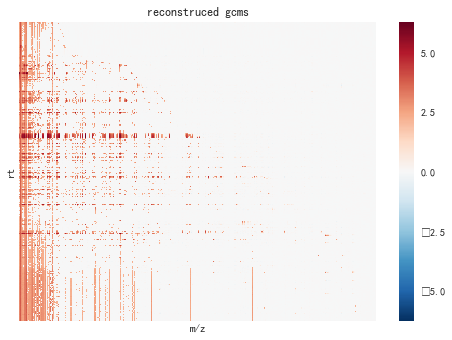

In [10]:
sns.heatmap(_sdf, yticklabels=False,xticklabels=False)
plt.xlabel('m/z')
plt.ylabel('rt')
plt.title("reconstruced gcms")
plt.show()
plt.close()

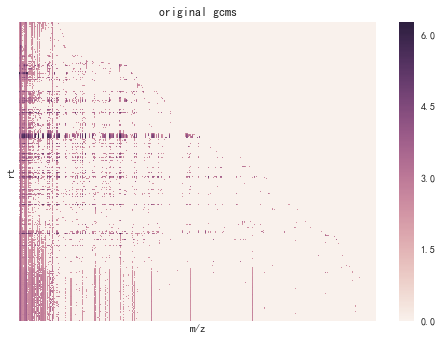

In [11]:
sns.heatmap(sdf,yticklabels=False,xticklabels=False)
plt.xlabel('m/z')
plt.ylabel('rt')
plt.title('original gcms')
plt.show()

#  PCA压缩
1. binning 以后很稀疏
2. PCA压缩(change of basis)信息损失比较小